
[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


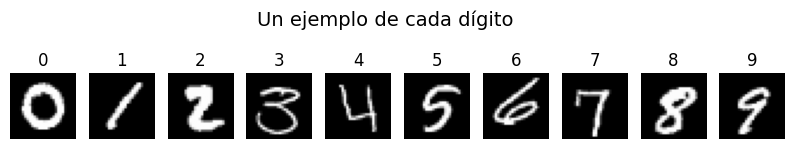

In [1]:
%pip install torch torchvision matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn # modulo de rrnn de PyTorch
import torch.optim as optim # optimizadores (gradient descent)
from torchvision import datasets, transforms # conjunto de datos
import pandas as pd
import numpy as np

# Cargar dataset local
df_train = pd.read_csv('digit-recognizer/train.csv')

# Diccionario para guardar una imagen por clase
examples = {}

# Recorremos el DataFrame hasta tener un ejemplo por clase
for _, row in df_train.iterrows():
    label = int(row['label'])
    if label not in examples:
        # Convertimos los píxeles a un array de 28x28
        pixels = row.drop('label').values.astype(np.uint8).reshape(28, 28)
        examples[label] = pixels
    if len(examples) == 10:
        break

# Mostrar los 10 dígitos
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(examples[i], cmap='gray')
    plt.title(str(i))
    plt.axis('off')

plt.suptitle("Un ejemplo de cada dígito", fontsize=14)
plt.show()

In [2]:
# Definición de la red neuronal
class SimpleFFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Capa oculta
        self.relu = nn.ReLU()             # Activación
        self.fc2 = nn.Linear(128, 10)     # Capa de salida

    def forward(self, x):
        x = x.view(-1, 28*28)             # Aplanar la imagen (de 28x28 a 784)
        x = self.relu(self.fc1(x))        # Activación sobre la capa oculta
        x = self.fc2(x)                   # Capa de salida sin activación (ya lo hace CrossEntropy)
        return x

In [3]:
# la inicializamos, definimos la función de coste y el optimizador
model = SimpleFFNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert the DataFrame to tensors
labels = torch.tensor(df_train['label'].values, dtype=torch.long)
images = torch.tensor(df_train.drop('label', axis=1).values, dtype=torch.float32) / 255.0  # Normalize pixel values

# Create a TensorDataset and DataLoader
dataset = TensorDataset(images, labels)
dataloader_train = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop 
for epoch in range(7): #
    for images, labels in dataloader_train:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0526
Epoch 2, Loss: 0.1242
Epoch 3, Loss: 0.0666
Epoch 4, Loss: 0.0495
Epoch 5, Loss: 0.0427
Epoch 6, Loss: 0.0073
Epoch 7, Loss: 0.0045


Tras varias pruebas he determinado que con 7 iteraciones es el numero con el que mejores resultados se han obtenido

In [5]:
# medimos performance
def compute_accuracy(model, data_loader):
    model.eval()  # Modo evaluación (desactiva dropout/batchnorm si existieran)
    correct = 0
    total = 0
    with torch.no_grad():  # No calculamos gradientes
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [6]:
df_test = pd.read_csv('digit-recognizer/test.csv')

# Create a TensorDataset and DataLoader
dataset = TensorDataset(images, labels)
dataloader_test = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
train_accuracy = compute_accuracy(model, dataloader_train)
print(f"Precisión en entrenamiento: {train_accuracy:.2f}%")

# Accuracy en test
test_accuracy = compute_accuracy(model, dataloader_test)
print(f"Precisión en test: {test_accuracy:.2f}%")

Precisión en entrenamiento: 98.90%
Precisión en test: 100.00%
